# Аренда самокатов GoFast

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. В основных данных есть информация о пользователях, их поездках и подписках.

Продакт-менеджеры хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов относительно прибыльности и выгодности подписки.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:


*без подписки:*
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;


*с подпиской Ultra:*
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

Исследование пройдёт в несколько этапов:
1. Обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных
4. Проверка гипотез.


### 1. Обзор данных

In [1]:
#импортируем библиотеку pandas
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt
#чтобы не появлялись предупреждения
import warnings
warnings.simplefilter("ignore")

In [2]:
#открываем файлы и записываем в переменные
try:
    riders = pd.read_csv('/datasets/rides_go.csv')
    users = pd.read_csv('/datasets/users_go.csv')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    riders = pd.read_csv('rides_go.csv')
    users = pd.read_csv('users_go.csv')
    subscriptions = pd.read_csv('subscriptions_go.csv')

#### 1.1 Датасет Users

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


В датасете хранится инфо о пользователях по характеристикам:
- `user_id` уникальный идентификатор пользователя
- `name` имя пользователя
- `age` возраст
- `city` город
- `subscription_type` тип подписки: free, ultra

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В таблице 1565 записей, 5 колонок. Пропуски отсутсвуют. 

In [5]:
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


В датасете только одна численная переменная - возраст. Остальные данные строчные.

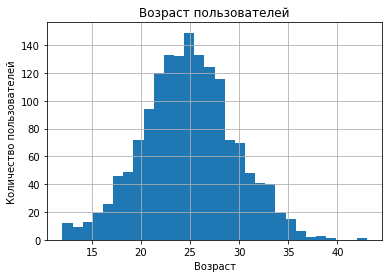

In [6]:
users.age.hist(bins = 30)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей');

#### 1.2 Датасет Riders

In [7]:
riders.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [8]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В Riders 18068 записей и содержится инфо:
- `user_id` уникальный идентификатор пользователя
- `distance` расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` продолжительность сессии (в минутах)
- `date` дата совершения поездки

В датасете есть две численные переменные - расстояние  и длительность поездки. Пропусков нет.

In [9]:
riders.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


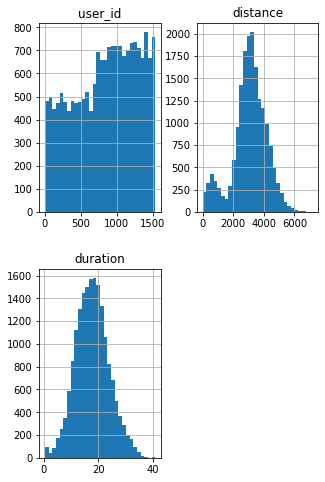

In [10]:
#визуализируем все численные данные 
riders.hist(figsize=(5, 8), bins = 30);

#### 1.3 Датасет Subscriptions

In [11]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [12]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Маленькая табличка с данными о типах пользования сервисом (бесплатно и с подпиской).
- `subscription_type` тип подписки: free и ultra
- `minute_price` стоимость одной минуты поездки по данной подписке
- `start_ride_price` стоимость начала поездки
- `subscription_fee` стоимость ежемесячного платежа


#### 1.4 Вывод

Для анализа получены три таблицы. В них нет пропусков. Users несет инфо о пользователях сервиса, Riders (самая объемная) - о поездках пользователей, Subscription - о ценовых характеристиках использования сервиса с подпиской и без.

### 2. Предобработка данных

#### 2.1 Пропуски

Как уже писала, пропуски в таблицах отсутсвуют.

In [13]:
riders.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [14]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

#### 2.2 Дубликаты

In [16]:
riders.duplicated().sum()

0

In [17]:
users.duplicated().sum()

31

In [18]:
#удалим дубликаты из таблицы users
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

In [19]:
#просмотрим на неявные дубликаты города в таблице Users
users.city.unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

**Микровывод** 

В таблице Users 31 дубликат. Удалили их. В остальных таблицах явных дубликатов нет, в subscriptions (где всего 2 строки) их и не может быть.

Неявных дубликатов также не найдено.

#### 2.3 Изменение типов данных

Изменим тип данных `date` в таблице Riders на datetime, т.к. при использовании этого столбца значения должны воприниматься как даты.

In [20]:
riders.date

0        2021-01-01
1        2021-01-18
2        2021-04-20
3        2021-08-11
4        2021-08-28
            ...    
18063    2021-11-04
18064    2021-11-16
18065    2021-11-18
18066    2021-11-27
18067    2021-12-29
Name: date, Length: 18068, dtype: object

In [21]:
riders['date'] = pd.to_datetime(riders['date'], format = '%Y-%m-%d')
riders.date

0       2021-01-01
1       2021-01-18
2       2021-04-20
3       2021-08-11
4       2021-08-28
           ...    
18063   2021-11-04
18064   2021-11-16
18065   2021-11-18
18066   2021-11-27
18067   2021-12-29
Name: date, Length: 18068, dtype: datetime64[ns]

In [22]:
riders.date.min()

Timestamp('2021-01-01 00:00:00')

In [23]:
riders.date.max()

Timestamp('2021-12-30 00:00:00')

В данных представлена информация о поездках за 2021 год.

#### 2.4 Добавим столбец в Riders

Создадим новый столбец с номером месяца на основе столбца `date`.

In [24]:
riders['month'] = riders['date'].dt.month
riders.month

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: month, Length: 18068, dtype: int64

#### 2.5 Вывод
В ходе предобработки:
- пропусков в данных нет
- дубликаты в таблице о поездках `riders` в количестве 31 шт, были удалены
- для `date` в таблице о поездках `riders` изменили тип данных на datetime
- добавили столбец `month` в таблице `riders` с номером месяца, в который совершена поездка

### 3. Исследовательский анализ данных

Посмотрим общую информацию о пользователях и поездках:

#### 3.1 Частота встречаемости городов

In [25]:
users.city.value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

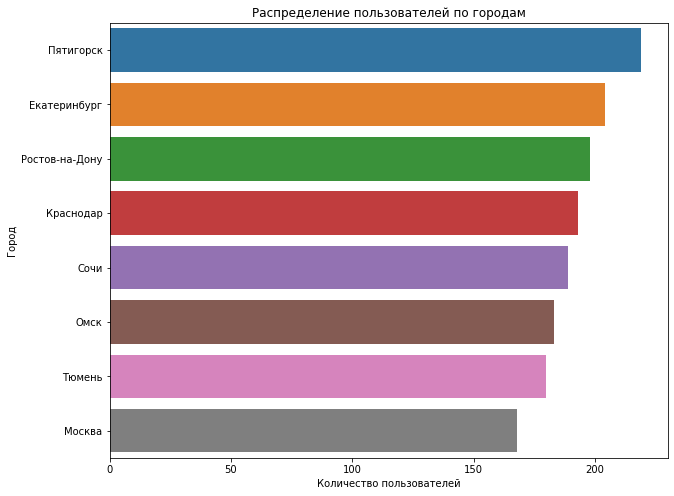

In [26]:
plt.figure(figsize=(10, 8)) 
ax = sns.countplot(y='city', data=users, order = users.city.value_counts().index);
ax.set(xlabel='Количество пользователей', ylabel='Город', title = 'Распределение пользователей по городам');

Пользователи распределены по городам довольно сбалансировано. Больше всего пользователей в Пятигорске, а меньше всего в Москве. 

#### 3.2 Cоотношение пользователей с подпиской и без подписки

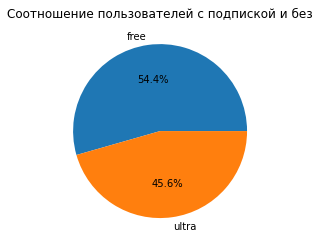

In [27]:
plt.title('Cоотношение пользователей с подпиской и без')
plt.pie(users.subscription_type.value_counts(), labels = users.subscription_type.value_counts().index, autopct='%1.1f%%')
plt.show()

In [28]:
users.subscription_type.value_counts(normalize=True)

free     0.544329
ultra    0.455671
Name: subscription_type, dtype: float64

Пользователей без подписки несколько больше, но, в целом, группы сбалансированы.

#### 3.3 Возраст пользователей

In [29]:
users.age.describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

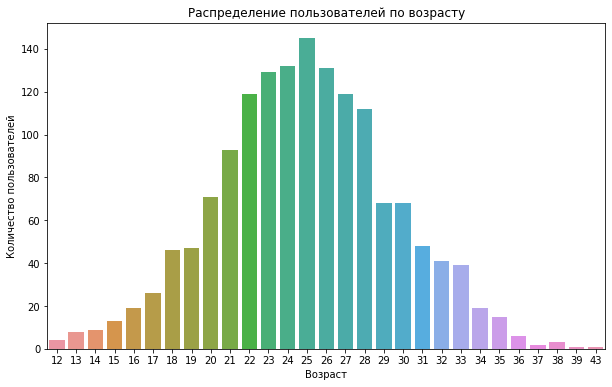

In [30]:
plt.figure(figsize=(10, 6)) 
ax = sns.countplot(x='age', data=users)
ax.set(xlabel='Возраст', ylabel='Количество пользователей', title = 'Распределение пользователей по возрасту');

Среди пользователей больше всего взрослый молодых людей в возрасте около 25 лет. Самым маленькие пользователи сервиса 12 лет, самым взрослым 43. 

#### 3.4 Расстояние, которое пользователь преодолел за одну поездку

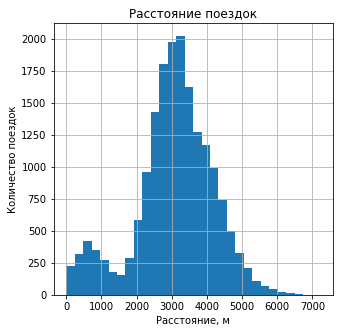

In [31]:
riders.hist('distance', figsize=(5, 5), bins = 30);
plt.title('Расстояние поездок')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок');

Чаще всего, за одну поездку пользователь проезжает 3000 км или немного больше.

Есть пользователи которые проехали совсем немного меньше 1 км или даже меньше. Такое малое расстояние может означать,что либо действительно столько нужно было проехать, либо пользователю не понравился опыт взаимодействия с самокатом и он решил его прекратить.

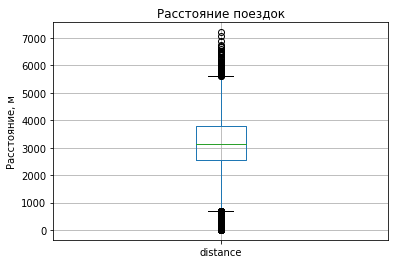

In [32]:
riders.boxplot('distance')
plt.title('Расстояние поездок')
plt.ylabel('Расстояние, м');

Посмотрим на данные о пользователях, совершивших короткие поездки

In [33]:
riders.distance.describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [34]:
Q1 = np.percentile(riders.distance, 25.)
Q3 = np.percentile(riders.distance, 75.)
print('Нижняя граница усов:', Q1 - 1.5*st.iqr(riders.distance))
print('Верхняя граница усов:', Q3 + 1.5*st.iqr(riders.distance))

Нижняя граница усов: 693.7317969370258
Верхняя граница усов: 5625.717298360568


In [35]:
riders.query('distance<=693')

,user_id,distance,duration,date,month
100,10,680.952663,5.150377,2021-02-21,2
149,15,634.891669,15.809350,2021-04-05,4
153,15,671.851433,12.031109,2021-11-15,11
197,21,518.341543,10.151870,2021-02-03,2
204,21,517.912395,14.219625,2021-10-01,10
...,...,...,...,...,...
18018,1531,375.107762,5.406654,2021-06-27,6
18031,1532,303.787850,7.792490,2021-05-21,5
18037,1532,662.468186,9.528773,2021-11-18,11
18043,1533,310.488247,10.642389,2021-02-21,2


In [36]:
riders.query('user_id==1534')

,user_id,distance,duration,date,month
18055,1534,4678.415899,15.228198,2021-01-20,1
18056,1534,2103.914120,13.425579,2021-02-28,2
18057,1534,3434.290912,14.366248,2021-04-29,4
18058,1534,195.447469,6.469074,2021-06-11,6
18059,1534,3214.021065,18.343604,2021-06-18,6
18060,1534,3644.708038,20.289416,2021-08-08,8
18061,1534,3977.744996,26.916544,2021-08-20,8
18062,1534,4928.173852,22.560373,2021-09-13,9
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11


In [37]:
riders.sort_values(by='distance').head(10)

,user_id,distance,duration,date,month
11555,1069,0.855683,10.001902,2021-01-31,1
9541,925,2.570787,3.011018,2021-10-19,10
13690,1223,4.329506,4.008958,2021-05-22,5
8658,861,6.784447,6.015656,2021-07-21,7
7841,796,7.097072,10.026614,2021-11-26,11
8906,880,11.283615,2.035632,2021-03-28,3
8324,835,12.233115,4.034952,2021-09-19,9
13940,1240,15.000606,10.045002,2021-08-20,8
15626,1364,15.366168,6.057623,2021-08-22,8
11862,1091,15.630873,13.044660,2021-03-29,3


Пользователи, которые совершали короткие поездки , ездили на самокате и на более длинные дистанции, и неоднократно. Наверное, дело не в том, что не понравился сервис, а в том, что такую дистанцию и надо было проехать. Но возможно иногда по каким-то причинам все же решили завершить поездку преждевременно,т.к. есть поездки, где расстояние равно считанным метрам.

In [38]:
riders.query('distance<=693').shape[0]/riders.shape[0]

0.050309940225813594

Коротких по расстоянию поездок в датасете примерно 5%.

#### 3.5 Продолжительность поездок

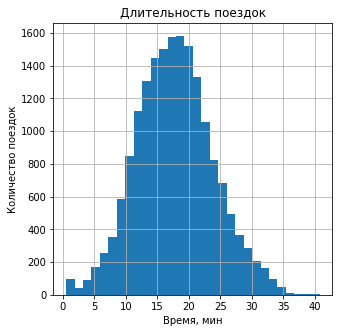

In [39]:
riders.hist('duration', figsize=(5, 5), bins = 30)
plt.title('Длительность поездок')
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок');

In [40]:
riders.duration.describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [41]:
riders.sort_values(by='duration').head(10)

,user_id,distance,duration,date,month
12013,1102,4602.122401,0.5,2021-08-01,8
17314,1483,4445.481070,0.5,2021-03-06,3
15029,1318,5894.633314,0.5,2021-03-28,3
7437,766,4539.088310,0.5,2021-12-22,12
12967,1172,4907.140751,0.5,2021-12-19,12
15015,1317,4593.389022,0.5,2021-07-16,7
13012,1176,4935.071045,0.5,2021-05-14,5
7508,772,4718.820996,0.5,2021-05-22,5
16589,1428,5059.187375,0.5,2021-05-06,5
9049,890,4848.485014,0.5,2021-11-20,11


In [42]:
riders.query('duration==0.5').shape[0]

95

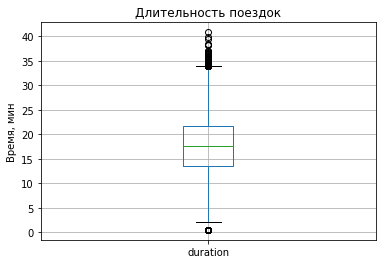

In [43]:
riders.boxplot('duration')
plt.title('Длительность поездок')
plt.ylabel('Время, мин');

В среднем, поездка занимает 18 минут.

Среди продолжительности поездки тоже есть аномально низкие. 95 поездок с продолжительностью полминуты при том, что расстояние таких поездок 4-5 км. Такие значения некорректны , где-то ошибка. Уберем эти значения, чтобы не получить искажения при подсчете выручки.

In [44]:
riders_clean = riders.query('duration>0.5')

In [45]:
#остаточная длина таблицы
riders_clean.shape[0]/riders.shape[0]

0.994742085454948

#### 3.6 Вывод

В ходе исследовательского анализа увидели, что:
- Пользователи распределены по городам довольно сбалансировано. Больше всего пользователей в Пятигорске, а меньше всего в Москве.
- Пользователей без подписки несколько больше, но, в целом, группы сбалансированы.
- Среди пользователей больше всего взрослый молодых людей в возрасте около 25 лет. Самым маленькие пользователи сервиса 12 лет, самым взрослым 43.
- Чаще всего, за одну поездку пользователь проезжает 3000 км или немного больше. При этом есть записи об очень коротких по расстоянию поездках - менее 700 м. 
- В среднем, поездка занимает 18 минут. Есть записи, где поездка заняла меньше половины минуты, а преодоленное расстояние составидо 4-5 км. Удалили записи с этой аномалией. 

### 4. Объединение данных

#### 4.1 Объединение

Объединим данные о пользователях, поездках и подписках в один датафрейм. 

In [46]:
all_data = riders_clean.merge(users, how='outer', on='user_id').merge(subscriptions,how='outer', on='subscription_type')

In [47]:
all_data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
17969,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
17970,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
17971,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [48]:
riders_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


Количество строк - 17973 -  в новой таблице `all_data`  равно исходной таблице `riders_clean`. Значит мы ничего не потеряли, все хорошо.

#### 4.2 Две новые таблицы по типу подписки

In [49]:
data_free = all_data.query('subscription_type=="free"').reset_index(drop=True)
data_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [50]:
data_ultra = all_data.query('subscription_type=="ultra"').reset_index(drop=True)
data_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


#### 4.3 Расстояние и время поездок для пользователей двух категорий

Длительность поездок для двух групп:

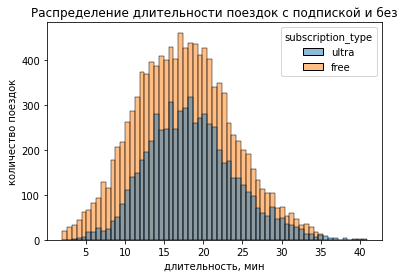

In [51]:
sns.histplot(all_data, x = 'duration', hue = 'subscription_type')
plt.xlabel('длительность, мин')
plt.ylabel('количество поездок')
plt.title('Распределение длительности поездок с подпиской и без');

Графики похожи между собой и похожи на нормальное распределение признака.

Расстояние поездок для двух групп:

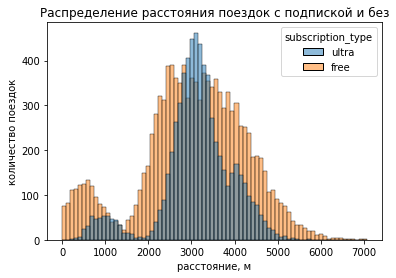

In [52]:
sns.histplot(all_data, x = 'distance', hue = 'subscription_type')
plt.xlabel('расстояние, м')
plt.ylabel('количество поездок')
plt.title('Распределение расстояния поездок с подпиской и без');

Гистограмма по поездках с подпиской имеет более узкий пик - меньший разброс по расстоянию поездок. Для поездок без подписки пик шире. 

На обоих графиках присутствует пик на расстоянии до 1000 м. В случае отсутствия подписки,он выше и сильнее смещен в сторону коротких поездок. Пользователи без подписки чаще совершают довольно короткие поездки.

#### 4.4 Вывод

- Таблицы riders, users, subscriptions объединили в один датасет all_data.

- Затем датасет all_data разделили на два новый по типу подписки - с инфо о поездках и пользователях без подписки data_free и с подпиской data_ultra.

- Еще раз посмотрели на распределения времени поездки и расстояния , но теперь по группам - с подпиской и без. Распределение длительности очень похожи для поездок с подпиской и без. Расстояние распределено в двух группах немного по-разному - без подписки больше разброс значений и больше очень коротких поездок.

### 5. Подсчет выручки

Сделаем сводную таблицу на основе объединенной таблицы all_data - найдем количество поездок, общее расстояние и длительность поездок за каждый месяц у каждого пользователя. 

Округлим длительность поездок в all_data до следующего целого числа.

In [53]:
all_data['duration'] = np.ceil(all_data['duration'])
all_data['duration']

0        26.0
1        16.0
2         7.0
3        19.0
4        27.0
         ... 
17968    20.0
17969    22.0
17970    19.0
17971    17.0
17972    16.0
Name: duration, Length: 17973, dtype: float64

In [54]:
data_agg = all_data.pivot_table(index=['user_id', 'month'],
                     values = ['distance', 'duration'], 
                     aggfunc={'distance': ['count','sum'], 'duration':'sum'})
data_agg.columns = ['count', 'distance_sum','duration_sum']
data_agg

count  distance_sum  duration_sum
user_id month                                   
1       1          2   7027.511294          42.0
        4          1    754.159807           7.0
        8          2   6723.470560          46.0
        10         2   5809.911100          32.0
        11         3   7003.499363          56.0
...              ...           ...           ...
1534    6          2   3409.468534          26.0
        8          2   7622.453034          48.0
        9          1   4928.173852          23.0
        11         4  13350.015305          78.0
        12         1   2371.711192          16.0

[11300 rows x 3 columns]

In [55]:
data_agg = data_agg.reset_index()

Добавим данные о типе подписки и тарифах в data_agg:

In [56]:
#типы подписок
for i in data_free['user_id'].unique():
    data_agg.loc[data_agg['user_id']==i,'subscription_type'] = 'free'
for i in data_ultra['user_id'].unique():
    data_agg.loc[data_agg['user_id']==i,'subscription_type'] = 'ultra'

In [57]:
data_agg = data_agg.merge(subscriptions, how = 'outer', on = 'subscription_type', )
data_agg

,user_id,month,count,distance_sum,duration_sum,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,ultra,6,0,199
1,1,4,1,754.159807,7.0,ultra,6,0,199
2,1,8,2,6723.470560,46.0,ultra,6,0,199
3,1,10,2,5809.911100,32.0,ultra,6,0,199
4,1,11,3,7003.499363,56.0,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...
11295,1534,6,2,3409.468534,26.0,free,8,50,0
11296,1534,8,2,7622.453034,48.0,free,8,50,0
11297,1534,9,1,4928.173852,23.0,free,8,50,0
11298,1534,11,4,13350.015305,78.0,free,8,50,0


Подсчитаем прибыль по каждому месяцу по каждому пользователю, добавим в сводную таблицу колонку `monthly_income` с этой прибылью.

Прибыль рассчитаем как *(общая длительность, мин) * (стоимость минуты) + (количество поездок) * (стоимость старта) + стоимость подписки*

In [58]:
data_agg['monthly_income'] = data_agg['duration_sum']*data_agg['minute_price']+data_agg['count']*data_agg['start_ride_price'] + data_agg['subscription_fee']

In [59]:
data_agg

,user_id,month,count,distance_sum,duration_sum,subscription_type,minute_price,start_ride_price,subscription_fee,monthly_income
0,1,1,2,7027.511294,42.0,ultra,6,0,199,451.0
1,1,4,1,754.159807,7.0,ultra,6,0,199,241.0
2,1,8,2,6723.470560,46.0,ultra,6,0,199,475.0
3,1,10,2,5809.911100,32.0,ultra,6,0,199,391.0
4,1,11,3,7003.499363,56.0,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
11295,1534,6,2,3409.468534,26.0,free,8,50,0,308.0
11296,1534,8,2,7622.453034,48.0,free,8,50,0,484.0
11297,1534,9,1,4928.173852,23.0,free,8,50,0,234.0
11298,1534,11,4,13350.015305,78.0,free,8,50,0,824.0


### 6. Проверка гипотез

#### 6.1 Тратят ли пользователи с подпиской больше времени на поездки? 

В пункте 4.3 мы визуально оценили, что распределения длительности поездок с подпиской и без подписки похожи качественно и количественно.

In [64]:
data_ultra['duration'].mean()

18.54198516280583

In [65]:
data_free['duration'].mean()

17.530771268800226

Сравним длительности с помощью теста Стьюдента. Т.к. распределены они примерно одинаково и близко к нормальному распределению, дисперсии их тоже близки.

Возьмем в качестве нулевой гипотезы утверждение, что средние двух наборов данных (ген.совокупностей) - с подпиской и без подписки -  равны. Альтернативная гипотеза - среднее набора данных с подпиской больше, чем без подписки.

In [66]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.704468074453899e-28
Отвергаем нулевую гипотезу


##### 6.1.1 Вывод

Действительно, несмотря на то, что средние значения близки, средняя длительность поездок пользователей с подпиской значимо больше, чем без подписки.

#### 6.2 Оптимальное расстояние поездки относительно износа самоката

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Нулевая гипотеза: Средняя дистанция поездки пользователя с подпиской равна 3130 м.

Альтернативная гипотеза: Средняя дистанция поездки пользователя с подпиской больше 3130 м.

In [67]:
interested_value = 3130 # оптимальное расстояние с точки зрения износа самоката

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    data_ultra['distance'], 
    interested_value, alternative = 'greater')

print('p-значение:', results.pvalue )

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


##### 6.2.1 Вывод

Отвергнуть нулевую гипотезу не можем, значит можем подтвердить предположение, что среднее расcтояние поездки подписчика близко к 3130 м, статистически значимо от него не отличается.

#### 6.3 Разница помесячной выручки с подпиской и без

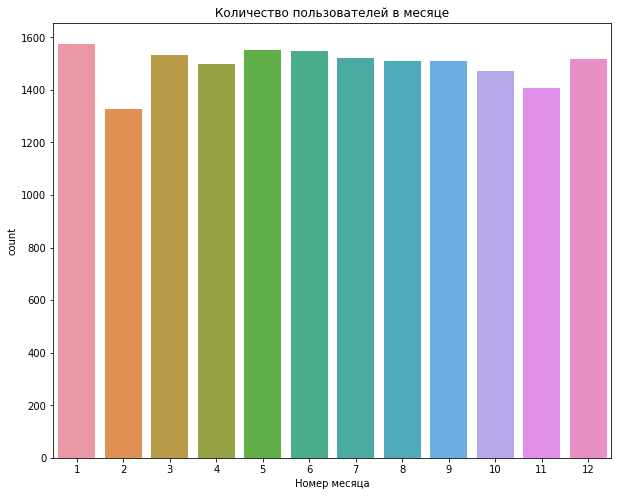

In [68]:
plt.figure(figsize=(10, 8)) 
sns.countplot(x='month', data=all_data)
plt.title('Количество пользователей в месяце')
plt.xlabel('Номер месяца');


Количество поездок, в целом, примерно равномерно распрделено по году.

In [69]:
data_agg[data_agg['user_id'].isin(data_ultra['user_id'])]['monthly_income'].mean()

362.7921906022502

In [70]:
data_agg[data_agg['user_id'].isin(data_free['user_id'])]['monthly_income'].mean()

329.3326437121324

В качестве нулевой гипотезы возьмем утверждение, что средние помесячные выручка по пользователю среди пользователей с подпиской и без нее равны. 

Альтернативная гипотеза - помесячная выручка от пользователей с подпиской выше, чем от тех, что без подписки.

In [71]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_agg[data_agg['user_id'].isin(data_ultra['user_id'])]['monthly_income'],
                       data_agg[data_agg['user_id'].isin(data_free['user_id'])]['monthly_income'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


##### 6.3.1 Вывод

Помесячная выручка от подписчиков значимо больше, чем выручка от пользователей без подписки. Подписчики активнее пользуются сервисом и соотвественно тратят на него больше.

#### 6.4 Количество обращений до и после обновления сервера

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ**

В таком случае необходимо воспользоваться тестом Стьюдента для проверки равенства средних зависимых выборок (данные "до  и после").

Метод в python : `st.ttest_rel(before, after)`

### 7. Распределения
#### 7.1 Промокоды на подписку

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 
5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

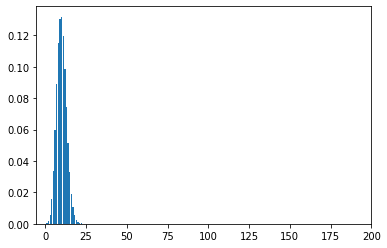

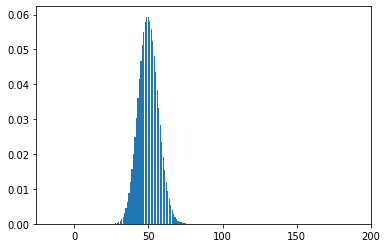

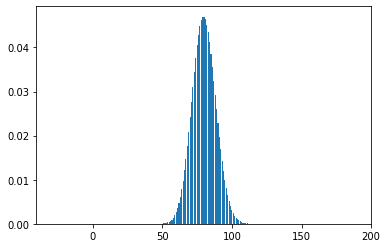

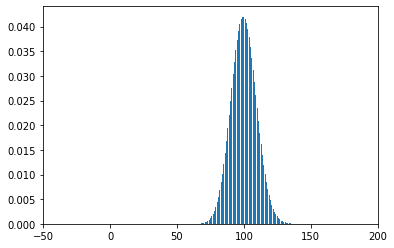

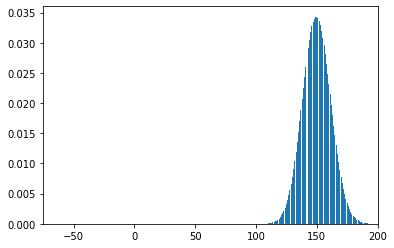

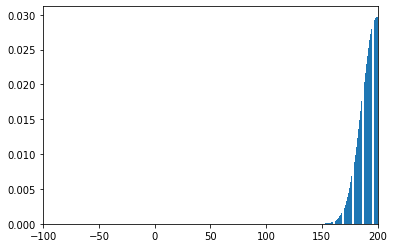

In [72]:
for n in [100, 500, 800,1000, 1500, 2000]: # количество попыток
    p = 0.1 # вероятность успеха

    distr = []

    for k in range(0, n + 1):
        current_value = binom.pmf(k, n, p)
        distr.append(current_value)
    
    plt.bar(range(0, n+1), distr)
    plt.xlim(right = 200)
    plt.show()

In [73]:
# задаём параметры биномиального распределения
n = 1500
p = 0.1

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение 
distr = st.norm(mu, sigma) 

interested_value = 100

# считаем вероятность получить значение меньше interested_value
result = distr.cdf(interested_value)
print(result)

8.413074170946365e-06


Вероятность не выполнить план при 1500 промокодов сильно меньше 5%.
Возьмем чуть меньше промокодов - 1000.

In [74]:
# задаём параметры биномиального распределения
n = 1000
p = 0.1

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение 
distr = st.norm(mu, sigma) 

interested_value = 100

# считаем вероятность получить значение меньше interested_value
result = distr.cdf(interested_value)
print(result)

0.5


Вероятность не выполнить план при 1000 промокодов 50%. 

In [75]:
# задаём параметры биномиального распределения
n = 1170
p = 0.1

mu = n * p
sigma = sqrt(n * p * (1 - p))
 
distr = st.norm(mu, sigma) 

interested_value = 100

result = distr.cdf(interested_value)
print(result)

0.04879359652776027


##### 7.1.1. Вывод
Перебрав несколько значений между 1500 и 1000 промокодов, получили, что, чтобы выполнить план (100 подписчиков после бесплатного месяца должны продлить подписку) минимум на 95%, необходимо раздать 1170 промокодов.

#### 7.2 Рассылка 
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [76]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))
 
distr = st.norm(mu, sigma) 

interested_value = 399500

result = distr.cdf(interested_value)
print(result)

0.15371708296369768


In [77]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>

def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

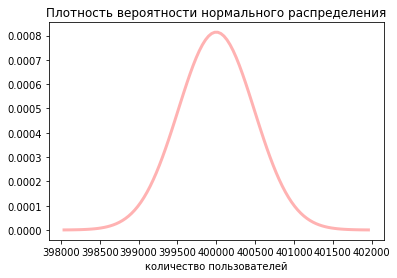

In [78]:
# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3)
plt.title('Плотность вероятности нормального распределения')
plt.xlabel('количество пользователей');

##### 7.2.1 Вывод

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет 15.4%

### 8. Общий вывод

*Обзор данных*

Для анализа получены три таблицы c данными сервиса аренды самокатов GoFast. `users_go.csv` несет инфо о пользователях сервиса, `rides_go.csv` (самая объемная) - о поездках пользователей, `subscriptions_go.csv` - о ценовых характеристиках использования сервиса с подпиской и без.

*Предобработка данных*

- В таблицах нет пропусков;
- В таблице с поездками был 31 дубликат, их удалили;
- Для даты в таблице с поездками изменили тип данных на datetime;
- Добавили столбец `month` в таблицу с поездками.  `month` содержит номер месяца, в который совершена поездка.

*Исследовательский анализ данных*

- Пользователи распределены по городам довольно сбалансировано. Больше всего пользователей в Пятигорске, а меньше всего в Москве.
- Пользователей без подписки немного больше, но, в целом, группы сбалансированы.
- Среди пользователей больше всего взрослый молодых людей в возрасте около 25 лет. Самым маленькие пользователи сервиса 12 лет, самым взрослым 43.
- Чаще всего, за одну поездку пользователь проезжает 3000 км или немного больше. При этом есть записи об очень коротких по расстоянию поездках. Эти значения могли возникнут в случае если пользователь решил преждевременно прекратить поездку.
- В среднем, поездка занимает 18 минут. Есть записи, где поездка заняла меньше половины минуты, а преодоленное расстояние составило 4-5 км. Удалили записи с этой аномалией.

*Объединение данных и подсчет выручки по месяцам и пользователям*
- Таблицы riders, users, subscriptions объединили в один датасет all_data. Затем датасет all_data разделили на два новый по типу подписки - с инфо о поездках и пользователях без подписки data_free и с подпиской data_ultra.

- Еще раз посмотрели на распределения времени поездки и расстояния , но теперь по группам - с подпиской и без. Распределение длительности очень похожи для поездок с подпиской и без. Расстояние распределено в двух группах немного по-разному - без подписки больше разброс значений и больше очень коротких поездок.

- Данные all_data агрегировали в сводную таблицу data_agg, где отразили количество поездок, общее расстояние и общую длительность поездок за месяц для каждого пользователя. 
- На основании таблицы data_agg подсчитали прибыль по каждому месяцу по каждому пользователю, добавили эту информацию в сводную таблицу колонку `monthly_income`.

*Проверка гипотез*

В ходе проверки гипотез показали, что:
- Средняя длительность поездок пользователей с подпиской значимо больше, чем без подписки. Соотвественно такие пользователи более "выгодны" для компании.

- Среднее расcтояние поездки подписчика значимо не отличается от 3130 м, а значит не превышает оптимальное расстояние с точки зрения износа самоката.

- Помесячная выручка от подписчиков значимо больше, чем выручка от пользователей без подписки. Подписчики активнее пользуются сервисом и соотвественно тратят на него больше.

*Распределения*
-  Чтобы выполнить план по увеличению числа подписчиков сервиса (100 подписчиков после бесплатного месяца должны продлить подписку) минимум на 95%, необходимо раздать 1170 промокодов.
- При рассылке пуш-уведомлений вероятность, что не более 399.5 тыс клиентов откроют его, составляет около 15.4%.

**Таким образом,** данный анализ показал, что подписчики выгодны сервису и за счет увеличения их количества и их лояльности можно увеличить выручку компании.
